In [175]:
!pip install opencv-python pillow matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git



  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-a9aqau8h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-a9aqau8h
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [176]:
import os

# Create a folder for the model
os.makedirs("model_weights", exist_ok=True)

!wget -P model_weights https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


--2025-12-10 05:56:07--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘model_weights/sam_vit_b_01ec64.pth.15’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   144MB/s    in 2.5s    

2025-12-10 05:56:09 (144 MB/s) - ‘model_weights/sam_vit_b_01ec64.pth.15’ saved [375042383/375042383]



In [177]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from segment_anything import sam_model_registry, SamPredictor


In [178]:
sam = sam_model_registry["vit_b"](checkpoint="model_weights/sam_vit_b_01ec64.pth")
predictor = SamPredictor(sam)

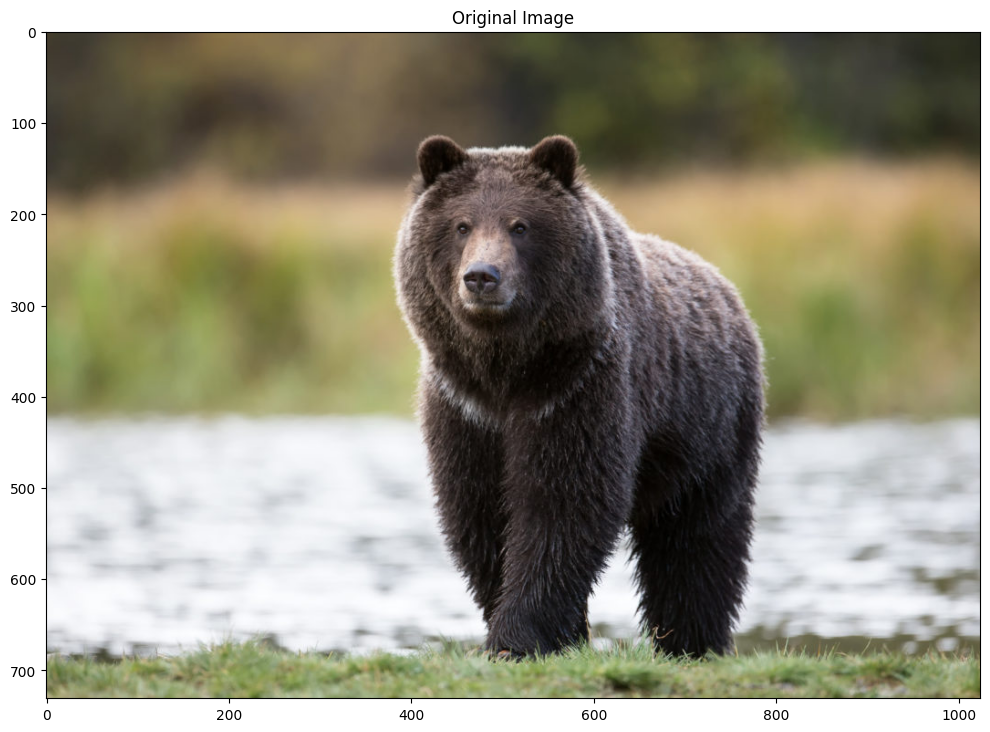

In [179]:
from PIL import Image
import urllib.request

# Load the image
image = cv2.imread("/content/white-collar_Pat-Roque-1024x731.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Display it
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("on")  # Keep axes so you can see pixel coordinates
plt.tight_layout()
plt.savefig("01_original_image.png", dpi=150, bbox_inches='tight')
plt.show()


In [180]:
# Set the image for the predictor
predictor.set_image(image_rgb)

# Define a point where the dog's body is
# The format is [x, y] where (0,0) is top-left corner
input_point = np.array([[512, 340]])
input_label = np.array([1])  # 1 means "segment this object"

# Get the segmentation masks
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

print(f"Segmentation complete!")
print(f"Generated {len(masks)} masks")
print(f"Mask scores: {scores}")

Segmentation complete!
Generated 3 masks
Mask scores: [0.9921615  0.99318403 0.69375485]


Best mask score: 0.9932


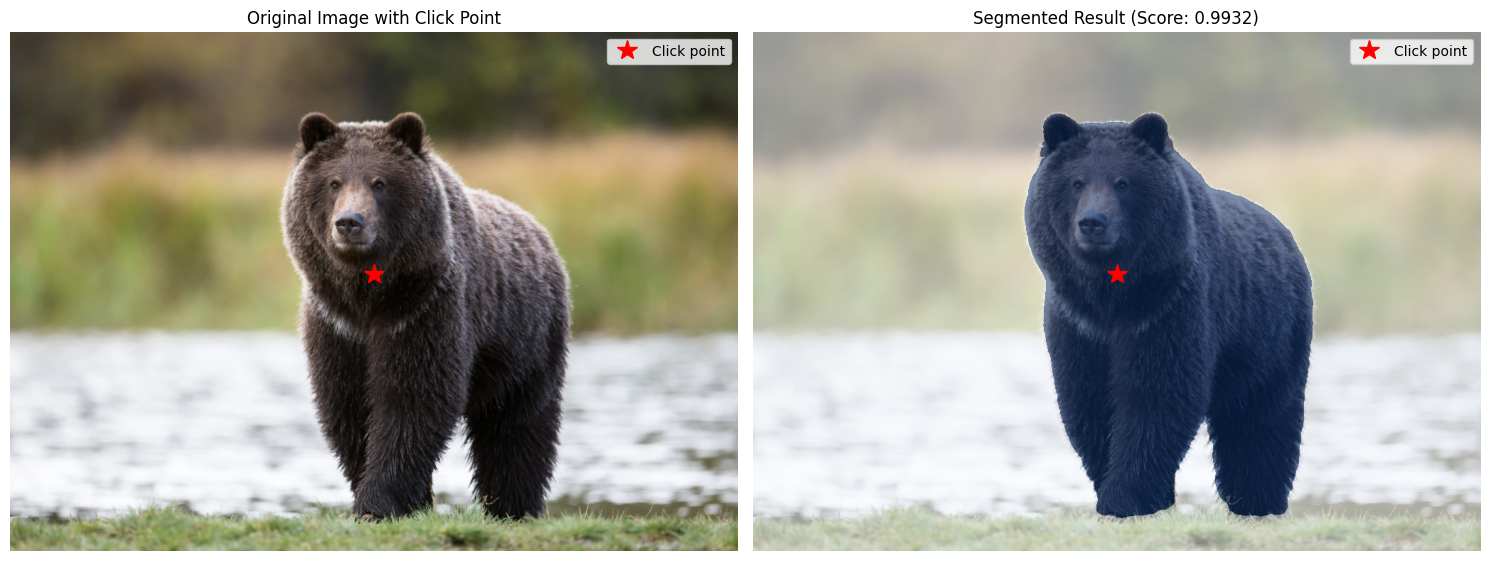

In [181]:

# The model returns multiple masks
best_mask_idx = np.argmax(scores)
best_mask = masks[best_mask_idx]

print(f"Best mask score: {scores[best_mask_idx]:.4f}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Original image
axes[0].imshow(image_rgb)
axes[0].plot(input_point[0, 0], input_point[0, 1], 'r*', markersize=15, label='Click point')
axes[0].set_title("Original Image with Click Point")
axes[0].legend()
axes[0].axis("off")

# Segmented result
axes[1].imshow(image_rgb)
axes[1].imshow(best_mask, alpha=0.5, cmap='Blues')  # Overlay mask in blue
axes[1].plot(input_point[0, 0], input_point[0, 1], 'r*', markersize=15, label='Click point')
axes[1].set_title(f"Segmented Result (Score: {scores[best_mask_idx]:.4f})")
axes[1].legend()
axes[1].axis("off")

plt.tight_layout()
plt.savefig("02_segmentation_result.png", dpi=150, bbox_inches='tight')
plt.show()

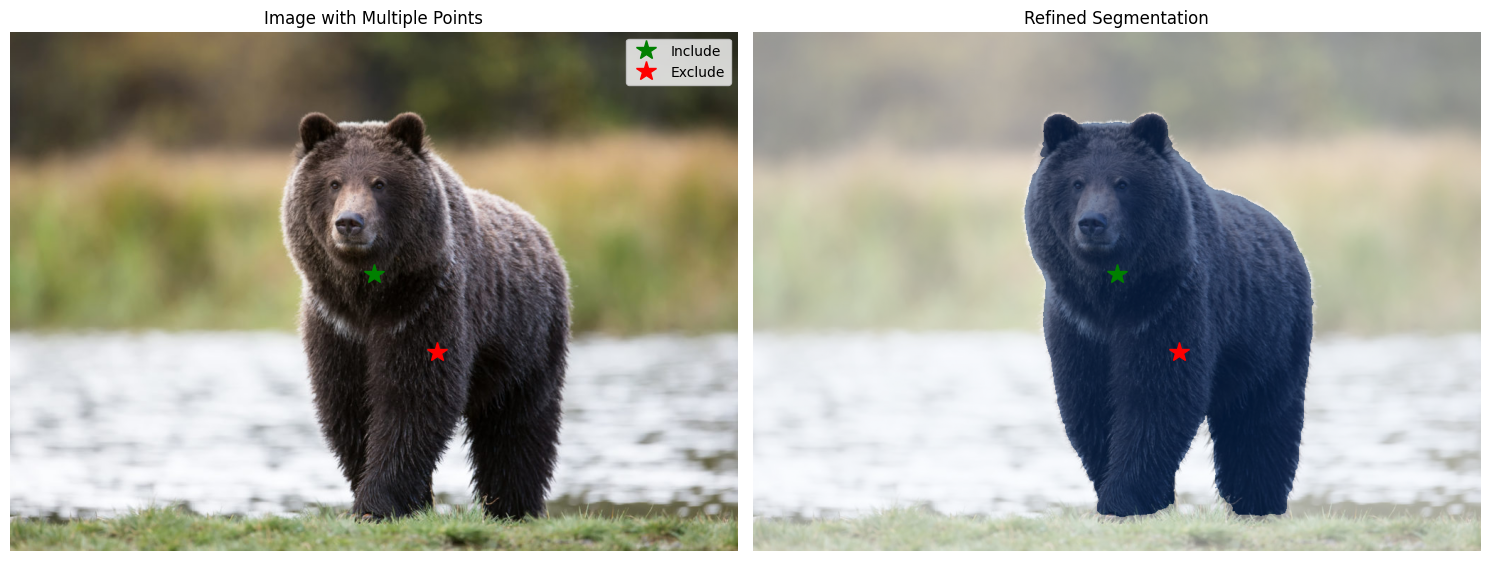

In [182]:

# Resetting and trying with TWO points to be more specific
predictor.set_image(image_rgb)

# Two points: one on the dog, one to exclude (set label=0 to exclude)
input_points = np.array([
    [512, 340],  # Point on dog body (include)
    [600, 450]   # Point on background (exclude)
])
input_labels = np.array([1, 0])  # 1=include, 0=exclude

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

best_mask_idx = np.argmax(scores)
best_mask = masks[best_mask_idx]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(image_rgb)
axes[0].plot(input_points[0, 0], input_points[0, 1], 'g*', markersize=15, label='Include')
axes[0].plot(input_points[1, 0], input_points[1, 1], 'r*', markersize=15, label='Exclude')
axes[0].set_title("Image with Multiple Points")
axes[0].legend()
axes[0].axis("off")

axes[1].imshow(image_rgb)
axes[1].imshow(best_mask, alpha=0.5, cmap='Blues')
axes[1].plot(input_points[0, 0], input_points[0, 1], 'g*', markersize=15)
axes[1].plot(input_points[1, 0], input_points[1, 1], 'r*', markersize=15)
axes[1].set_title(f"Refined Segmentation")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("03_multi_point_segmentation.png", dpi=150, bbox_inches='tight')
plt.show()


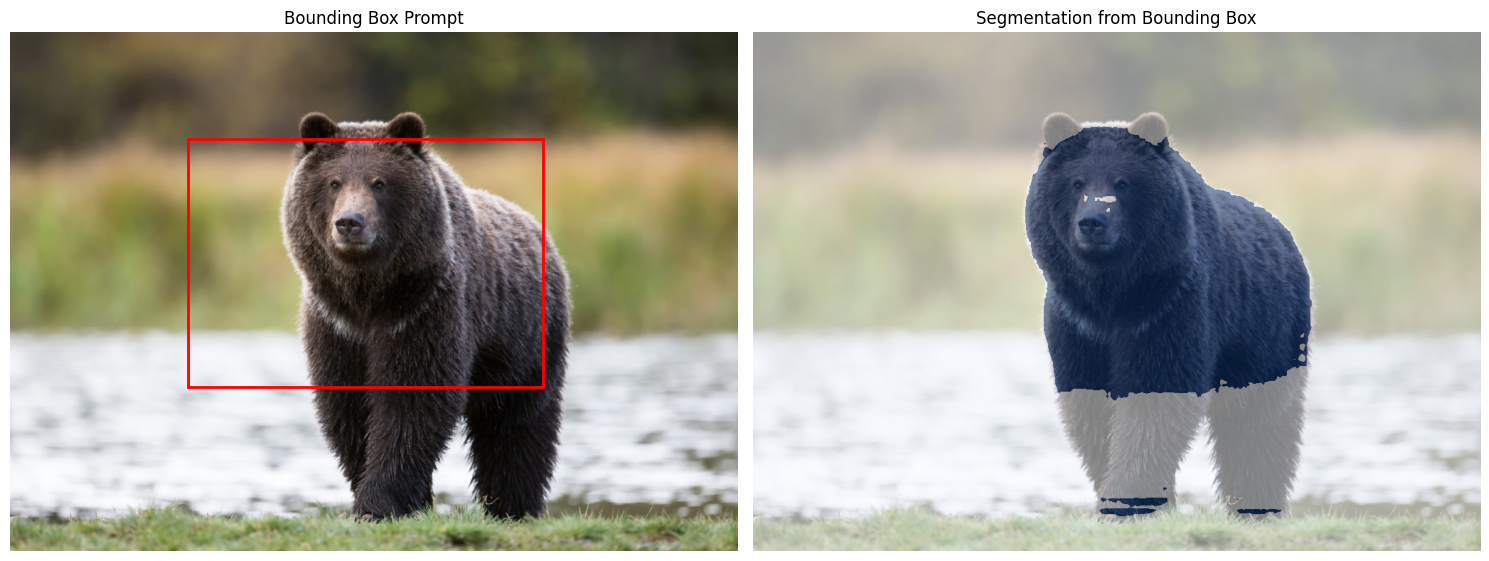

In [183]:
#  Reset for bounding box
predictor.set_image(image_rgb)

# Define a bounding box around the dog: [x_min, y_min, x_max, y_max]
input_box = np.array([250, 150, 750, 500])  # Adjust as needed

masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=True,
)

best_mask_idx = np.argmax(scores)
best_mask = masks[best_mask_idx]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(image_rgb)
rect = Rectangle((input_box[0], input_box[1]),
                 input_box[2]-input_box[0],
                 input_box[3]-input_box[1],
                 linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)
axes[0].set_title("Bounding Box Prompt")
axes[0].axis("off")

axes[1].imshow(image_rgb)
axes[1].imshow(best_mask, alpha=0.5, cmap='Blues')
axes[1].set_title(f"Segmentation from Bounding Box")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("04_bbox_segmentation.png", dpi=150, bbox_inches='tight')
plt.show()


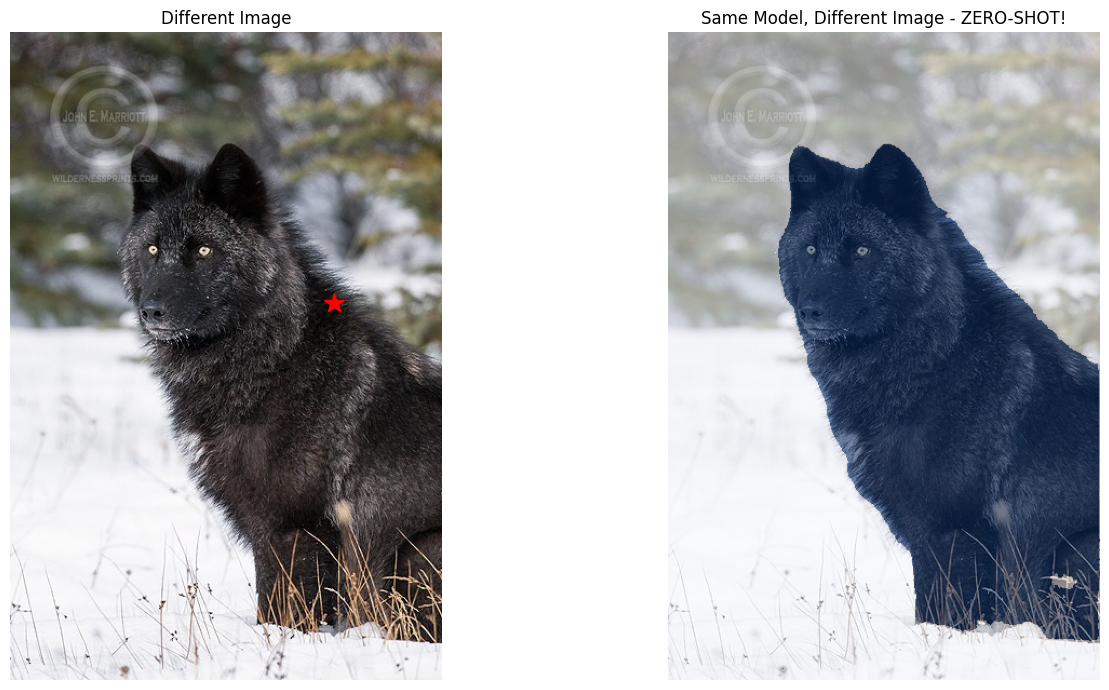

In [187]:


# Test on Different Image



image2 = cv2.imread("/content/img_7166.jpg")
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Segment without retraining - zero-shot!
predictor.set_image(image2_rgb)
input_point = np.array([[300, 250]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

best_mask = masks[np.argmax(scores)]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(image2_rgb)
axes[0].plot(input_point[0, 0], input_point[0, 1], 'r*', markersize=15)
axes[0].set_title("Different Image")
axes[0].axis("off")

axes[1].imshow(image2_rgb)
axes[1].imshow(best_mask, alpha=0.5, cmap='Blues')
axes[1].set_title("Same Model, Different Image - ZERO-SHOT!")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("05_zero_shot_example.png", dpi=150, bbox_inches='tight')
plt.show()


In [185]:

# Timing Test (Show Speed)

import time

# Time the image encoding (expensive, done once)
start = time.time()
predictor.set_image(image_rgb)
encoding_time = time.time() - start

# Time the mask prediction (fast, can be done many times)
start = time.time()
input_point = np.array([[640, 400]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
)
prediction_time = time.time() - start

print("=" * 50)
print("TIMING RESULTS")
print("=" * 50)
print(f"Image Encoding Time: {encoding_time*1000:.2f} ms")
print(f"Mask Prediction Time: {prediction_time*1000:.2f} ms")
print(f"Total Time: {(encoding_time+prediction_time)*1000:.2f} ms")
print("\nThis shows why SAM is efficient:")
print("- Encode image once (~1 second)")
print("- Then prompt very fast (~50ms)")
print("=" * 50)


TIMING RESULTS
Image Encoding Time: 26858.82 ms
Mask Prediction Time: 222.96 ms
Total Time: 27081.79 ms

This shows why SAM is efficient:
- Encode image once (~1 second)
- Then prompt very fast (~50ms)


In [186]:
print("All segmentations saved as:")
print("  - 01_original_image.png")
print("  - 02_segmentation_result.png")
print("  - 03_multi_point_segmentation.png")
print("  - 04_bbox_segmentation.png")
print("  - 05_zero_shot_example.png")


All segmentations saved as:
  - 01_original_image.png
  - 02_segmentation_result.png
  - 03_multi_point_segmentation.png
  - 04_bbox_segmentation.png
  - 05_zero_shot_example.png
